## To illustrate the impact of poisoning on a classification method, let's use a simple binary classification example with logistic regression. We/'ll create a synthetic dataset where the goal is to classify points into two classes based on two features. Then, we'll introduce poisoned data to show how it can affect the classifier's decision boundary.

### First we'll create a clean dataset suitable for binary classification

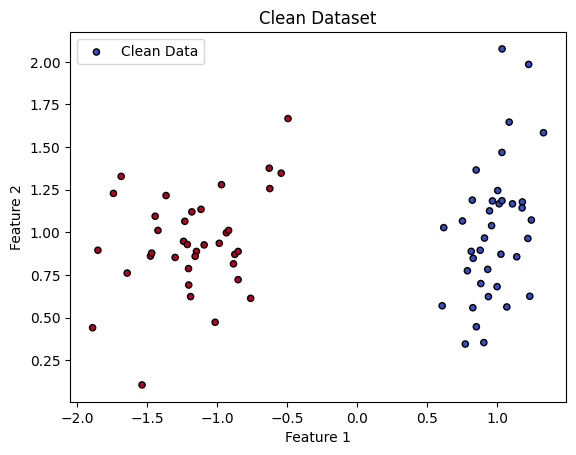

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate a synthetic binary classification dataset
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.5], flip_y=0, random_state=1)

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Visualize the clean dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', s=20, label='Clean Data')
plt.title('Clean Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### Next we'll introduce poisoned data points that will target the classifier's decision boundary

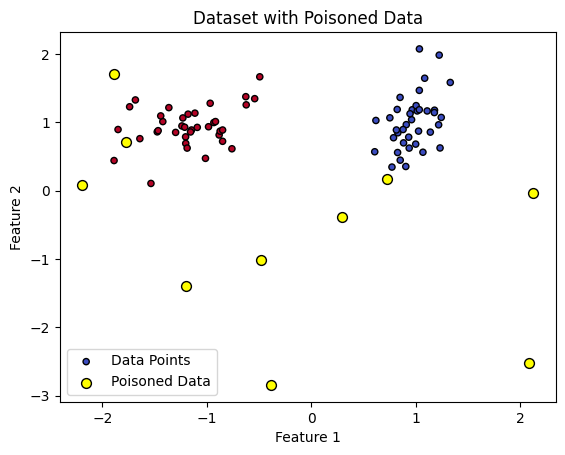

In [2]:
# Generate poisoned data points
np.random.seed(2)  # Ensure reproducibility
X_poison = np.random.uniform(low=-3, high=3, size=(10, 2))  # Generate points in the feature space
y_poison = np.zeros(10)  # Incorrect class for poisoning

# Add the poisoned data to the training set
X_train_poisoned = np.vstack([X_train, X_poison])
y_train_poisoned = np.hstack([y_train, y_poison])

# Visualize the dataset with poisoned data
plt.scatter(X_train_poisoned[:, 0], X_train_poisoned[:, 1], c=y_train_poisoned, cmap='coolwarm', edgecolor='k', s=20, label='Data Points')
plt.scatter(X_poison[:, 0], X_poison[:, 1], c='yellow', edgecolor='k', s=50, label='Poisoned Data')
plt.title('Dataset with Poisoned Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### Finally, we'll train logistic regression models on both the clean and poisoned datasets to observe the impact.

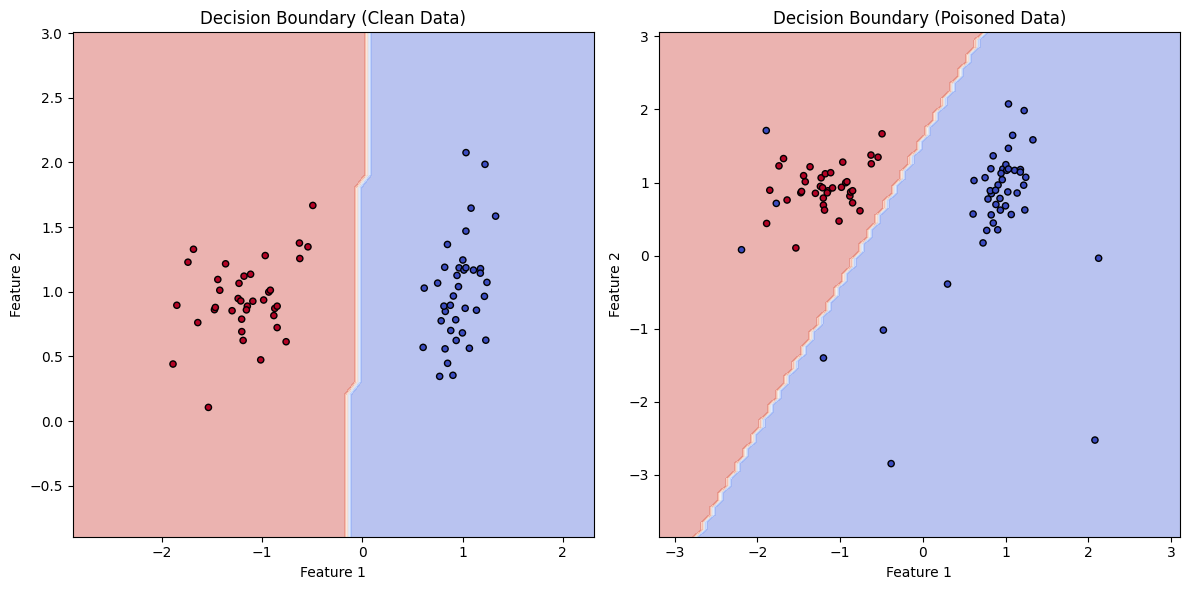

In [9]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression on clean data
clf_clean = LogisticRegression().fit(X_train, y_train)

# Train logistic regression on poisoned data
clf_poisoned = LogisticRegression().fit(X_train_poisoned, y_train_poisoned)

# Function to plot decision boundaries
def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Plot decision boundaries for both models
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(clf_clean, X_train, y_train, 'Decision Boundary (Clean Data)')
plt.subplot(1, 2, 2)
plot_decision_boundary(clf_poisoned, X_train_poisoned, y_train_poisoned, 'Decision Boundary (Poisoned Data)')
plt.tight_layout()
plt.show()

### As we can see, there is a significant alteration in the decision boundry creating a heavy skew. Detecting a poison attack in a classification context, especially with logistic regression, involves identifying data points that unduly influence the model's decision boundary. One effective approach for this is anomaly detection, which can be based on leveraging characteristics of the data that distinguish normal data points from anomalies (or poisoned points). A common technique for anomaly detection in such scenarios is the use of Isolation Forests, which are particularly suited for high-dimensional datasets and can efficiently detect outliers.

### First, we'll use an Isolation Forest to identify anomalies in our combined dataset (clean + poisoned). Isolation Forest is an unsupervised learning algorithm that isolates anomalies instead of profiling normal data points.

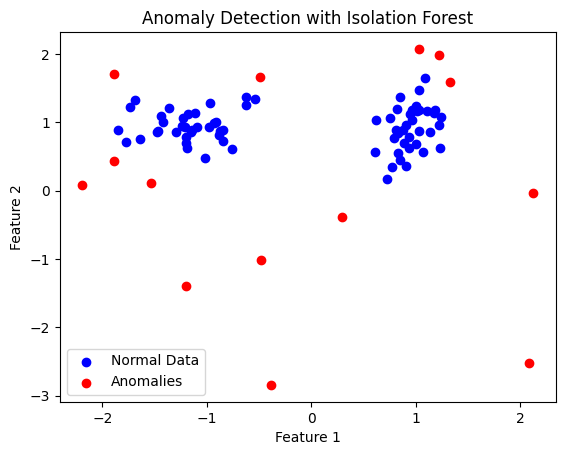

In [10]:
from sklearn.ensemble import IsolationForest

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(random_state=42, contamination='auto')  # 'auto' lets the algorithm determine the contamination factor
iso_forest.fit(X_train_poisoned)

# Predict anomalies (1 for normal, -1 for anomaly)
anomalies = iso_forest.predict(X_train_poisoned)

# Visualize the detected anomalies
plt.scatter(X_train_poisoned[anomalies == 1, 0], X_train_poisoned[anomalies == 1, 1], c='blue', label='Normal Data')
plt.scatter(X_train_poisoned[anomalies == -1, 0], X_train_poisoned[anomalies == -1, 1], c='red', label='Anomalies')
plt.title('Anomaly Detection with Isolation Forest')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### After identifying the anomalies, we filter them out to clean the dataset from poisoned data points before retraining the model.

In [11]:
# Filter out the anomalies
X_train_filtered = X_train_poisoned[anomalies == 1]
y_train_filtered = y_train_poisoned[anomalies == 1]

# Train a new logistic regression model on the filtered data
clf_filtered = LogisticRegression().fit(X_train_filtered, y_train_filtered)

### Now, let's compare the decision boundary of the model trained on the filtered dataset to the ones trained on the clean and poisoned datasets.

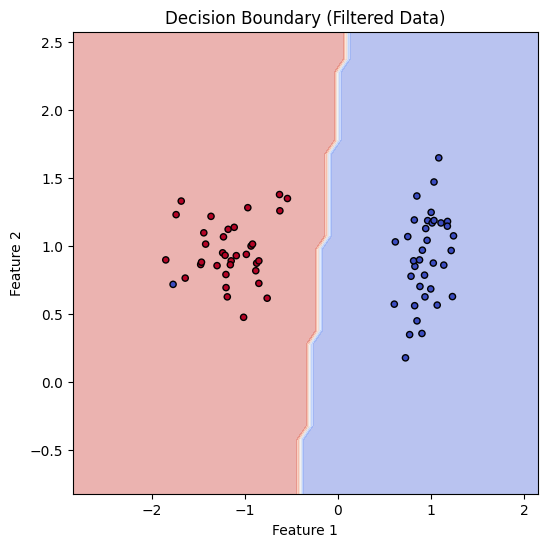

In [12]:
# Plot decision boundaries for the model trained on filtered data
plt.figure(figsize=(6, 6))
plot_decision_boundary(clf_filtered, X_train_filtered, y_train_filtered, 'Decision Boundary (Filtered Data)')
plt.show()